In [164]:
#import data
import pandas as pd
import numpy as np
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [165]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


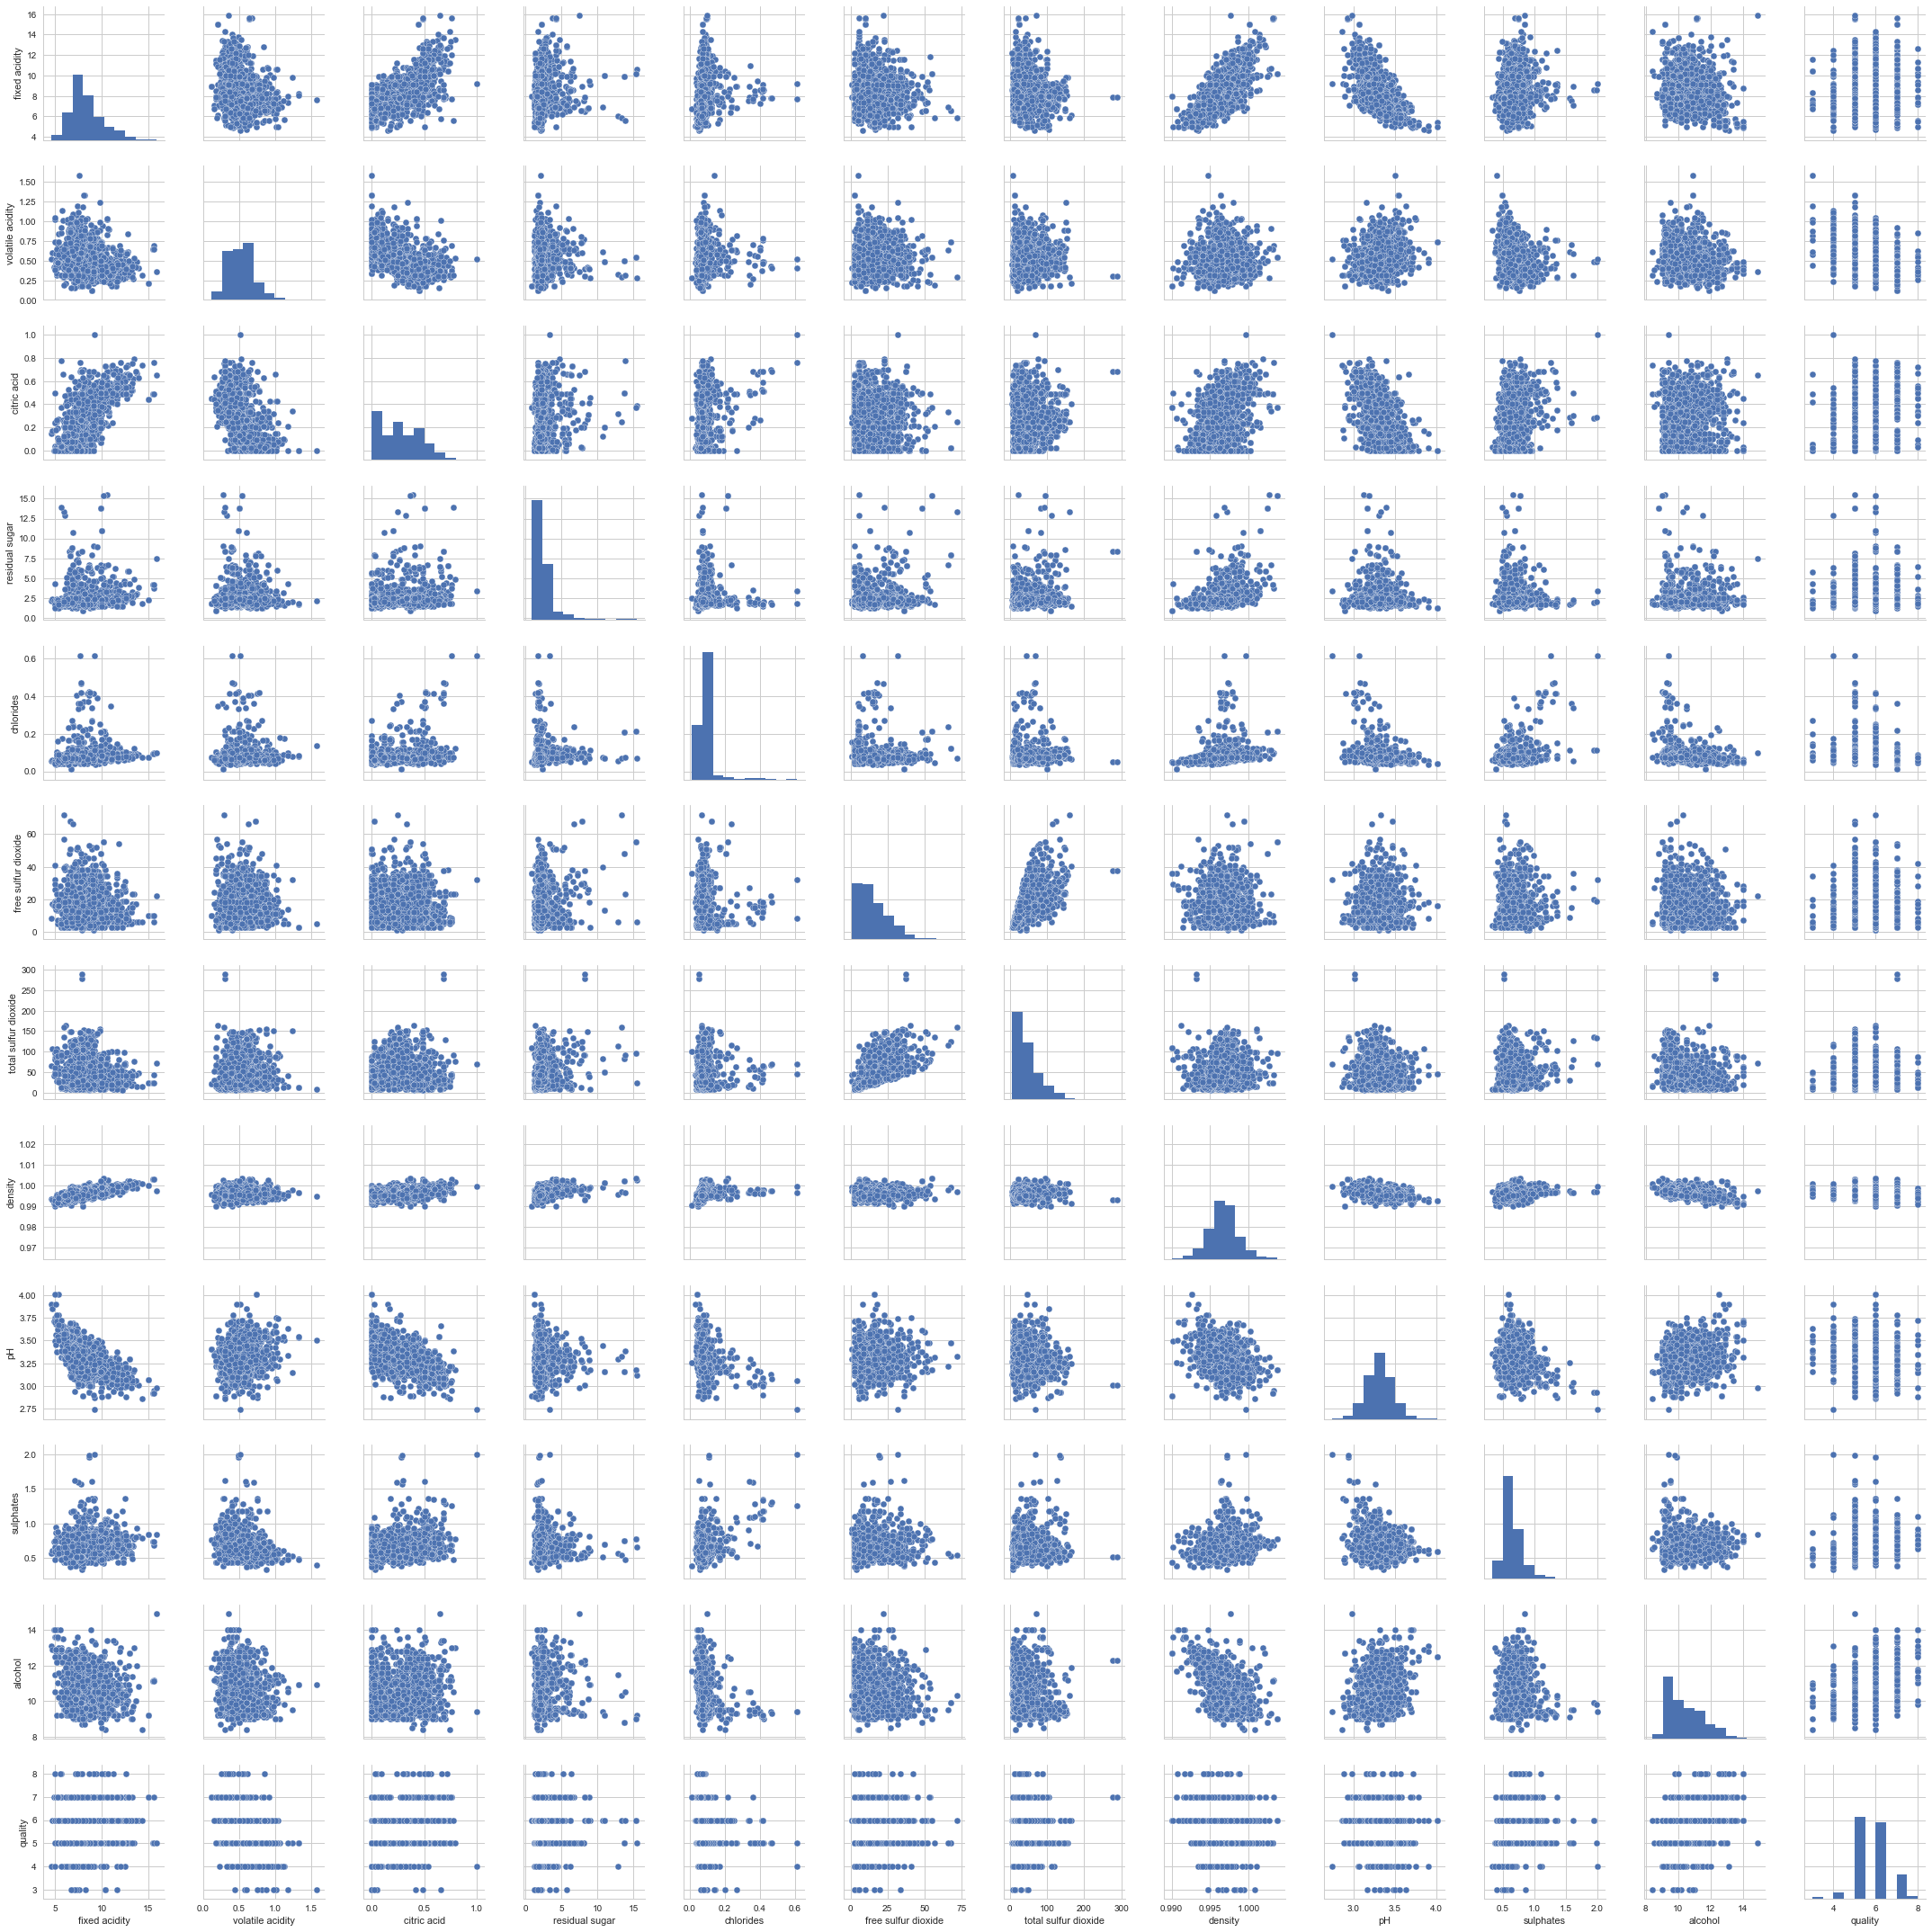

In [166]:
#plot the scatterplot matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='notebook')
cols =list(df.columns)

sns.pairplot(df, size=2.5)
plt.tight_layout()
plt.show()

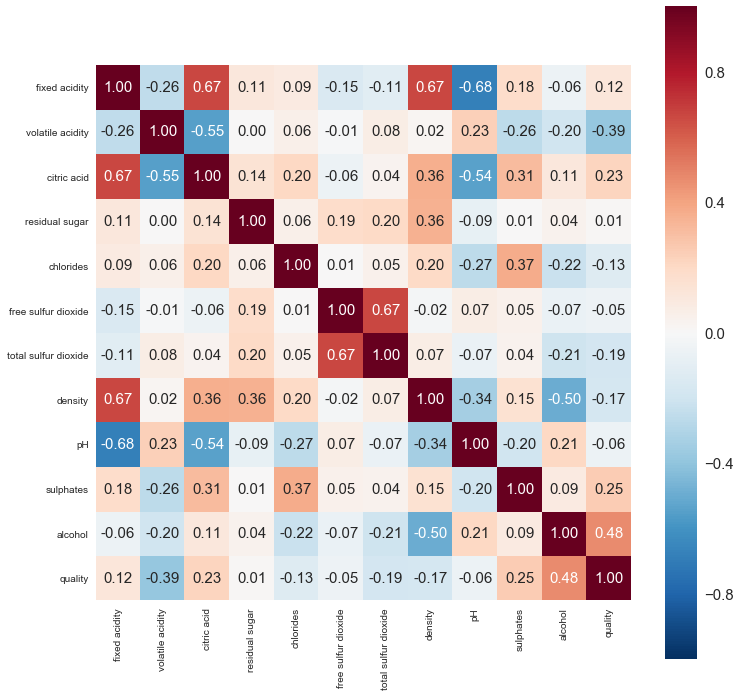

In [167]:
#plot the correlation matrix
plt.subplots(1, 1, figsize=(12, 12), sharex=True)
cm = np.corrcoef(df.values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size': 15},
                 yticklabels=list(df.columns), xticklabels=list(df.columns))
plt.show()

In [168]:
#change the labels into numbers
from sklearn.preprocessing import LabelEncoder

#quality_mean=df.iloc[:,-1].mean()
#I initially used mean value(about 5.6) as threshold,but the accuracy of classifiers is lower than those using 6 as threshold
y=(df['quality'].values>6)
X = df.iloc[:,:-1].values
#X = df.loc[:,['volatile acidity','alcohol']]
le = LabelEncoder()
y = le.fit_transform(y)
le.transform([True, False])

array([1, 0], dtype=int64)

In [169]:
#split the dataset into trainig set and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,test_size=0.30, random_state=0)

 1) alcohol                        0.166865
 2) volatile acidity               0.128626
 3) sulphates                      0.121136
 4) density                        0.091739
 5) citric acid                    0.089406
 6) total sulfur dioxide           0.076572
 7) fixed acidity                  0.072315
 8) chlorides                      0.070014
 9) residual sugar                 0.066358
10) pH                             0.058791
11) free sulfur dioxide            0.058178


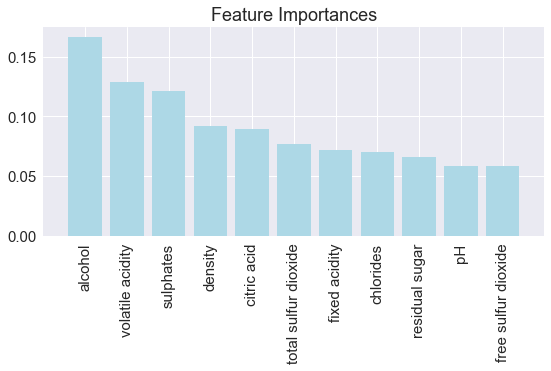

In [170]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df.columns[:-1]
forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,n_jobs=-1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        color='lightblue',
        align='center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

From the correlation matrix and random forest we can see that the two features which have the largest correlation with quality are volatile acidity and alcohol, so we choose these two features for training in the following steps.

In [171]:
#slip the new dataset with only two features
X = df.loc[:,['volatile acidity','alcohol']].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,test_size=0.30, random_state=0)

In [172]:
# use k-fold cross-validation to get mean accuracy
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10, 
                                random_state=1,
                                n_jobs=2)
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
std = StandardScaler()
X_std = std.fit_transform(X)
scores=[]
X1=X
for clf,clfname in zip([tree, forest,knn],['tree','forest','knn']):
    if clf == knn:
        X1=X_std #in knn, we need standardized data
        
    scores = cross_val_score(estimator=clf, X=X1, y=y, cv=10, n_jobs=1)
    print('CV Accuracy（%s）: %.3f+/-%.3f' % (clfname,np.mean(scores), np.std(scores)))

CV Accuracy（tree）: 0.857+/-0.033
CV Accuracy（forest）: 0.829+/-0.039
CV Accuracy（knn）: 0.847+/-0.027


In [173]:
# the function of decision regions plotting
from IPython.display import Image
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02, test_idx=None):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

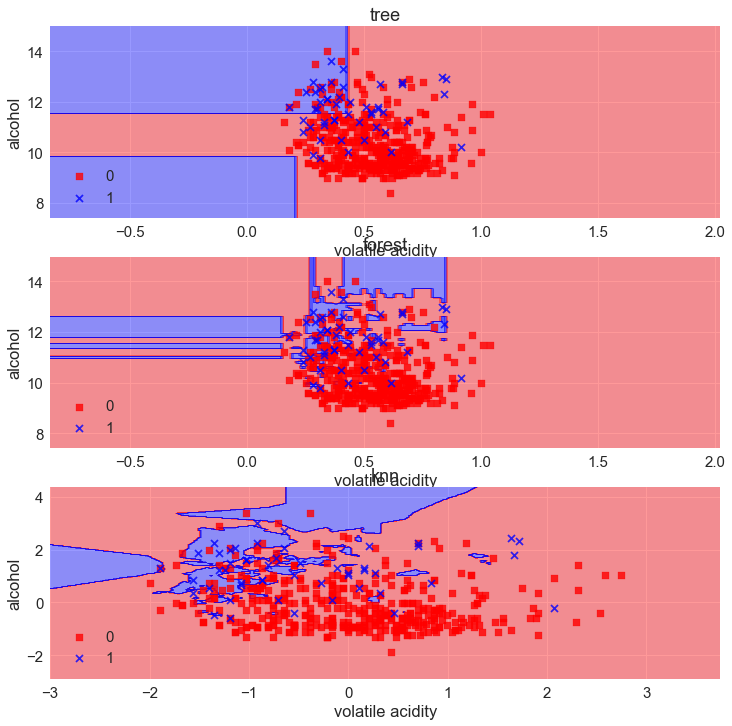

In [174]:
#plot the decision regions
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)
plt.subplots(3,1,figsize=(12, 12),squeeze=False)
X1_train=X_train
X1_test=X_test
for x,clf,clfname in zip([1,2,3],[tree, forest,knn],['tree','forest','knn']):
    if clf == knn:
        X1_train=X_train_std
        X1_test=X_test_std       
        
    clf.fit(X1_train, y_train)
    y_test_pred=clf.predict(X1_test) 
    
    plt.subplot(3,1,x)
    plot_decision_regions(X1_test, y_test, classifier=clf)
    plt.xlabel('volatile acidity')
    plt.ylabel('alcohol')
    plt.legend(loc='lower left')
    plt.title(clfname)
    
plt.show()
   


C:\Users\cjyjy\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


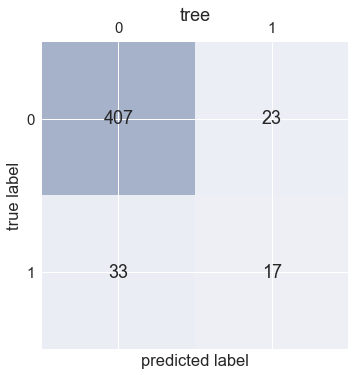

C:\Users\cjyjy\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


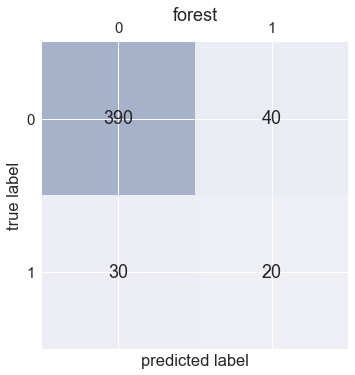

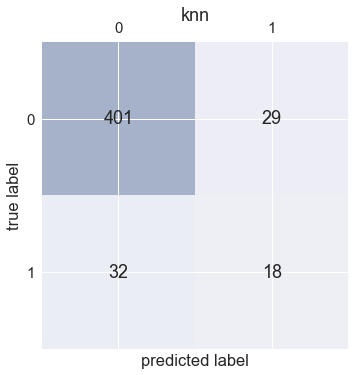

In [175]:
#plot the condusion matrix
from sklearn.metrics import confusion_matrix

for x,clf,clfname in zip([1,2,3],[tree, forest,knn],['tree','forest','knn']):
    if clf == knn:
        X1_train=X_train_std
        X1_test=X_test_std       
    
    clf.fit(X1_train, y_train)
    y_test_pred=clf.predict(X1_test) 
    
    confmat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    plt.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            plt.text(x=j, y=i,s=confmat[i, j],
                 va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.legend(loc='lower left')
    plt.title(clfname)
    plt.show()
   